# IFT608: Devoir sur l'apprentissage par renforcement (DQN)

    
**Date de remise :** 

Le but de ce devoir est d'expérimenter la méthode deep Q-Learning.

Les objectifs seront de compléter les implémentations d'agents RL qui apprendront une politique paramétrée en utilisant des réseaux neuronaux pour résoudre la tâche [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/). La tâche CartPole consiste à apprendre à un agent comment équilibrer un poteau sur le chariot sans tomber pendant un temps maximum.

Vous analyserez également le comportement de votre agent sur différentes méthodes qui définissent sa politique à l'aide de graphiques des récompenses obtenues.

![Cartpole](https://gymnasium.farama.org/_images/cart_pole.gif)

[Vous pouvez trouver plus de details sur cet environement ici](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

## Rappel

![Q-Learning](https://github.com/djeffkanda/djeffkanda.github.io/blob/master/ift/assets/images/qlearning.jpg?raw=true)

## Algorithm DQN

![algo](https://i.stack.imgur.com/DEmcS.png)

### Installation et importation des librairies 

In [1]:
# type hinting 
from typing import Sequence, Tuple, Dict, Any, Optional
from collections import namedtuple, deque
from itertools import count
import itertools


import numpy as np
import random
import math

# torch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim

# env
import gymnasium as gym
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder

# data manipulation, colab dispaly, and plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output

# misc util
import random, glob, base64, itertools
from pathlib import Path
from pprint import pprint

plt.style.use('seaborn-v0_8-darkgrid');

### Fonction pour visualiser l'environnement dans colab

In [2]:
def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

# commented for jupyter in vscode
# display = Display(visible=0, size=(1400, 900))
# display.start(); 

### Classes de base

In [3]:
# objects to record transitions

Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def sample_recent(self, batch_size):
        return list(itertools.islice(self.memory, len(self) - batch_size, len(self)))

    def __len__(self):
        return len(self.memory)

In [4]:
# Classe pour construire un modèle
class Model(nn.Module):
    def __init__(self, features: Sequence[int], fn=nn.ReLU):
        """Fully-connected Network

        Args:
            features: a list of ints like: [input_dim, 16, 16, output_dim]
        """
        super(Model, self).__init__()
        
        layers = []
        for i in range(len(features) - 1):
            layers.append(
                nn.Linear(
                    in_features=features[i],
                    out_features=features[i + 1],
                    )
            )
            if i != len(features) - 2:
                layers.append(fn())
        
        self.net = nn.Sequential(*layers)
        
    def forward(self, input):
        return self.net(input)

In [5]:
# Classe pour un agent de base
class BaseAgent(object):
  """ The base agent class function.
  """

  def __init__(self, config: Dict[str, Any]):
        """
        args:
            config: configuration dictionary
        """
        self.config = config

        # # set seed
        # np.random.seed(seed=config['seed'])
        # random.seed(config['seed'])
        # torch.manual_seed(config['seed'])

        # environment
        self.seed = config['seed']
        self.env = gym.make(**config['env_id'])
        self.env_monitor = gym.make(**config['env_id_monitor'])

        # build models

        self.batch_size = config['batch_size']
        self.discount = config['discount']
        self.eps_start = config['eps_start']
        self.eps_end = config['eps_end']
        self.eps_decay = config['eps_decay']
        self.tau = config['tau']
        self.lr = config['learning_rate']

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_model = Model(
            [self.env.observation_space.shape[0]] + 
            config['policy_layers'] + # note that these are only the intermediate layers
            [self.env.action_space.n], fn=config['policy_activation']
        ).to(self.device)

        self.target_model = Model(
            [self.env.observation_space.shape[0]] + 
            config['policy_layers'] + # note that these are only the intermediate layers
            [self.env.action_space.n], fn=config['policy_activation']
        ).to(self.device)
        self.target_model.load_state_dict(self.policy_model.state_dict())


        self.optimizer = torch.optim.AdamW(
            self.policy_model.parameters(), 
            lr=config['learning_rate'],
            amsgrad=True
        )

        self.memory = ReplayMemory(10000)
        self.episode_durations = []
        self.steps_done = 0


  def plot_durations(self, show_result=False):
    plt.figure(1, figsize=(10,15))
    durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if True:
        if not show_result:
            ipythondisplay.display(plt.gcf())
            ipythondisplay.clear_output(wait=True)
        else:
            ipythondisplay.display(plt.gcf())


  def _make_returns(self, rewards: np.ndarray):
        """ Compute the cumulative discounted rewards at each time step

        args:
            rewards: an array of step rewards

        returns:
            returns: an array of discounted returns from that timestep onward
        """
        returns = np.zeros_like(rewards)
        returns[-1] = rewards[-1]
        for t in reversed(range(len(rewards) - 1)):
            returns[t] = rewards[t] + self.gamma * returns[t + 1]
        return returns

  # Method to implement
  def optimize_model(self, n_episodes: int) -> np.ndarray:
        """ 

        args:
            n_episodes: number of trajectories in dataset

        returns:
            returns: the total discounted reward of each trajectory/episode.
        """
        
        raise NotImplementedError
        
  def train(self, n_episodes: int, n_iterations: int, plot: bool = True, plot_each_ep: bool = True) -> Sequence[np.ndarray]:
        """ Train.
        args:
            n_episodes: number of episodes for each gradient step
            n_iterations: determine training duration
        """

        raise NotImplementedError
        

  def get_action(self, state):
    sample = random.random()
    eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
    self.steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return self.policy_model(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[self.env.action_space.sample()]], device=self.device, dtype=torch.long)



  @staticmethod
  def plot_rewards(rewards: Sequence[np.ndarray], ax: Optional[Any] = None):
      # Plotting
      r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
      if ax is None:
          sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
      else:
          sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd', ax=ax);

  def evaluate(self):
        """ Evaluate and visualize a single episode.
        """

        env = gym.make(**self.config['env_id_monitor'])
        self.monitor_env = VideoRecorder(env, "./gym-results.mp4") #, force=True, video_callable=lambda episode: True)
        observation, _ = self.monitor_env.env.reset() #seed=self.seed)
        observation = torch.tensor(observation, dtype=torch.float, device=self.device)[None, :]
        reward_episode = 0
        done = False
        self.policy_model.eval()
        with torch.no_grad():    
          while not done:
              self.monitor_env.capture_frame()
              
              action = self.get_action(observation)
              observation, reward, terminated, truncated, info = self.monitor_env.env.step(int(action))
              done = terminated or truncated
              observation = torch.tensor(observation, dtype=torch.float, device=self.device)[None, :]
              reward_episode += reward

        self.policy_model.train()
        self.monitor_env.close()
        show_video("./")
        print(f'Reward: {reward_episode}')


### DQL Agent

In [6]:
# source : https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

class DQLAgent(BaseAgent):

  def optimize_model(self):
    """ 
        args:
            n_episodes: number of trajectories in dataset

        returns:
            
        """
        
    if len(self.memory) < self.batch_size:
        return

    if self.config['sampler'] == 'recent':
      transitions = self.memory.sample_recent(self.batch_size)
    else:
      transitions = self.memory.sample(self.batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=self.device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_model
    state_action_values = self.policy_model(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(self.batch_size, device=self.device)
    with torch.no_grad():
        next_state_values[non_final_mask] = self.target_model(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * self.discount) + reward_batch

    # Compute Huber loss

    criterion = self.config['loss_function']
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(self.policy_model.parameters(), 100)
    self.optimizer.step()

        
  def train(self, n_episodes: int,  plot: bool = True, plot_each_ep: bool = True) -> Sequence[np.ndarray]:
    """ Train.
        args:
            n_episodes: number of episodes for each gradient step
            n_iterations: determine training duration
        """
    plt.ion()
    for i_episode in range(n_episodes):
      # Initialize the environment and get it's state
      state, _ = self.env.reset()
      state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
      for t in count():
          action = self.get_action(state)
          observation, reward, terminated, truncated, _ = self.env.step(action.item())
          reward = torch.tensor([reward], device=self.device)
          done = terminated or truncated

          if terminated:
              next_state = None
          else:
              next_state = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)

          # Store the transition in memory
          self.memory.push(state, action, next_state, reward)

          # Move to the next state
          state = next_state

          # Perform one step of the optimization (on the policy network)
          self.optimize_model()

          # Soft update of the target network's weights
          # θ′ ← τ θ + (1 −τ )θ′
          target_net_state_dict = self.target_model.state_dict()
          policy_net_state_dict = self.policy_model.state_dict()

          for key in policy_net_state_dict:
              target_net_state_dict[key] = policy_net_state_dict[key] * self.tau + target_net_state_dict[key] * (1-self.tau)
          self.target_model.load_state_dict(target_net_state_dict)

          if done:
              self.episode_durations.append(t + 1)
              if plot_each_ep:
                self.plot_durations()
              break

    print('Complete')
    if plot:
      self.plot_durations(show_result=True)
      plt.ioff()
      plt.show()


### Entrainement de l'agent DQL

In [7]:
# Vous serez noté sur base de la sortie de cette cellule, donc veuillez l'exécuter.
# Voici un exemple de configuration adaptée à la question ci-dessus. Gardez la même configuration.
config = {
    'env_id': dict(id="CartPole-v1"),
    'env_id_monitor': dict(id="CartPole-v1", render_mode="rgb_array_list", disable_env_checker=True),
    'seed': 0,
    'policy_layers': [128, 128], # les couches intermédiaires du réseau neuronal
    'learning_rate': 1e-4,       # le pas d'apprentissage ou taux d'apprentissage
    'policy_activation':nn.ReLU, # la fonction d'activation
    'loss_function': nn.SmoothL1Loss(), # nn.MSELoss(), # la fonction de perte (nn.SmoothL1Loss())
    'batch_size': 128,            
    'discount': 0.99,              # le paramètre d'escompte
    'eps_start' : 0.9,
    'eps_end' : 0.05,
    'eps_decay':1000,
    'tau': 0.005,
    'memory' : 10000,
    'sampler': 'random' # recent
}


agent1 = DQLAgent(config)

Complete


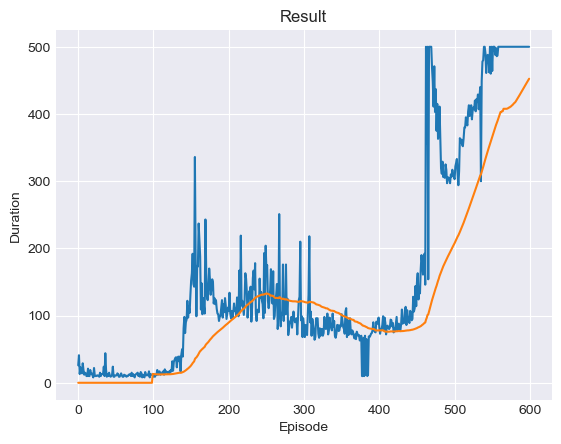

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
plt.ioff()
agent1.train(600)

In [9]:
agent1.evaluate()

Moviepy - Building video ./gym-results.mp4.
Moviepy - Writing video ./gym-results.mp4



Moviepy - Done !
Moviepy - video ready ./gym-results.mp4


Reward: 500.0


# Questions

### 1. 

1.1. Si votre impementation est correcte, expliquez pourquoi après 350 episodes, les épisodes durent plus lontemps qu'au début de l'entraînement? **\[5 points\]**

1.2. Expliquer dans quel cas il est nécessaire de représenter la fonction d'utilité Q à l'aide d'un approximateur de fonction paramétrée ? **\[5 points\]**

1.1 Il est tout à fait logique, si l'implémentation est correcte, que le temps des épisodes augmente à partir d'un certain seuil (ici, lors de notre exécution, à partir de 150 épisodes). En effet, l'agent commence à apprendre de plus en plus et donc il perd moins rapidement à chaque épisode d'où un temps plus élevé à chaque épisode (i.e qu'il arrive à garder le baton plus longtemps). Cependant, sa performance peut aussi décroitre puis s'améliorer comme on le voit sur le graphique.

1.2 En utilisant la version itérative, on sait que $Q_i$ va converger vers $Q^*$ lorsque $i \rightarrow \infty$. Cependant, lorsqu'on a énormément d'actions $a$ et d'états $s$ (e.g si $s$ représente des pixels), cette version n'est absolument pas scalable car il est nécessaire de calculer $Q(s,a)$ pour chaque pair $(a_i,s_i)$. La solution est donc d'utiliser un approximateur de fonction paramétrée tel un réseau de neurone pour approcher $Q^*$.

### 2. 
Quels sont les avantages de l'utilisation d'un tampon de relecture (replay buffer) ? **\[10 points\]**

En utilisant un réseau de neurone comme approximateur de fonction paramétrée, on effectue en arrière plan une descente de gradient stochastique pour minimiser une fonction de perte. Or, cette descente est efficace lorsque les données sont indépendantes et non-corrélées. Par conséquent, un tampon de relecture permet de sauvegarder tout type d'expérience variée et indépendante entre chaque épisode. Cela permet donc à l'agent de mieux apprendre car le réseau de neurone arrive à approximer d'une meilleure manière. Bien plus, en ayant accès à un pool d'expérience variée, l'agent évite d'oublier les cas dont il a déjà fait affaire (e.g, dans notre cas, lorsque le baton tend toujours à gauche).  

### 3. 
Quelle est l'importance de faire un échantillonnage aléatoire sur le tampon de relecture au lieu de choisir les dernières transitions consécutives pour mettre à jour les poids du réseau de neurones $Q_θ$ ? **\[10 points\]**

Si on effectue un échantillonnage par événement récent, on perd tout l'intérêt de l'utilisation d'un tampon de relecture, car le réseau de neurone apprendra uniquement sur des données consécutives qui seront fortement corrélées. De plus, il oubliera ses expériences passées. Il est donc nécessaire de choisir un échantillonnage aléatoire afin d'obtenir des données variées et non corrélées. 

### 4. 
Comparez, avec commentaires, les courbes de la durée des épisodes lorsque l'agent est entraîné avec du `random` ( échantillonnage aléatoire) et `recent` (les dernières transitions consécutives) batch du replay buffer. **\[20 points\]**

Complete
Complete


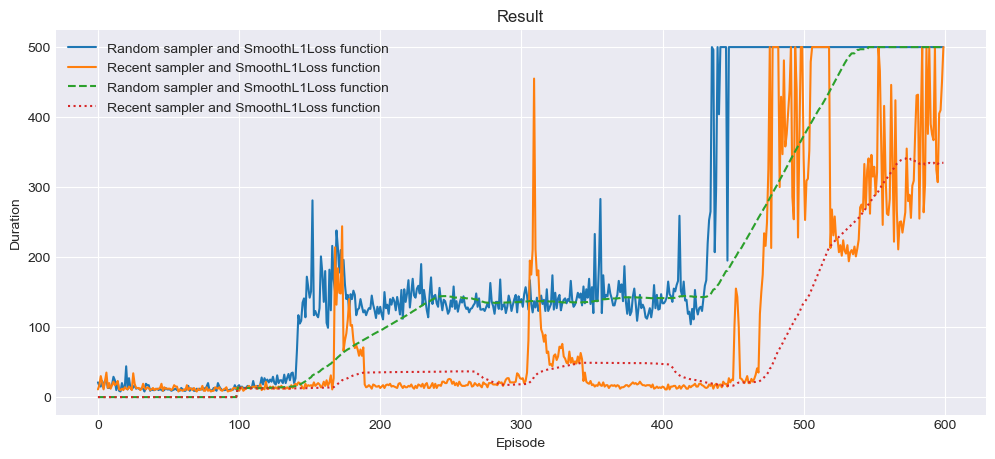

In [12]:
def plot_durations_comparison(n_episodes: int, question_number: int, config: Dict[str, Any]):
    config['sampler'] = 'random'
    config['loss_function'] = nn.SmoothL1Loss()

    a1 = DQLAgent(config)
    a1.train(n_episodes, plot=False, plot_each_ep=False)
    
    if question_number == 4:
        config['sampler'] = 'recent'
    elif question_number == 5:
        config['loss_function'] = nn.MSELoss()
    else:
        raise ValueError('Question number not recognized: use 4 or 5 only as input value')

    a2 = DQLAgent(config)
    a2.train(n_episodes, plot=False, plot_each_ep=False)

    durations_a1 = torch.tensor(a1.episode_durations, dtype=torch.float)
    durations_a2 = torch.tensor(a2.episode_durations, dtype=torch.float)

    plt.figure(1, figsize=(12,5))
    plt.title('Result')
    plt.xlabel('Episode')
    plt.ylabel('Duration')

    label_a2 = "Recent sampler and SmoothL1Loss function" if question_number == 4 else "Random sampler and MSELoss function"
    plt.plot(durations_a1.numpy(), label = "Random sampler and SmoothL1Loss function")
    plt.plot(durations_a2.numpy(), label = label_a2)
    
    if len(durations_a1) >= 100:
        means_a1 = durations_a1.unfold(0, 100, 1).mean(1).view(-1)
        means_a1 = torch.cat((torch.zeros(99), means_a1))

        means_a2 = durations_a2.unfold(0, 100, 1).mean(1).view(-1)
        means_a2 = torch.cat((torch.zeros(99), means_a2))

        plt.plot(means_a1.numpy(), linestyle='dashed', label="Random sampler and SmoothL1Loss function")
        plt.plot(means_a2.numpy(), linestyle='dotted', label=label_a2)

    plt.legend()
    plt.show()

plot_durations_comparison(600,4,config)

On remarque, comme discuté auparavant, que l'échantillonnage aléatoire permet d'obtenir des épisodes beaucoup plus longs, i.e, que l'agent apprend mieux et performe mieux. Et cela, se voit tout au long des épisodes. 

### 5. 
Tracez dans le même graphique la durée des épisodes lorsque l'agent est entraîné en utilisant l'erreur quadratique moyenne (EQM) et la perte [SmoothL1 Loss](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html\#torch.nn.SmoothL1Loss)  . Rapportez vos observations et dites laquelle des pertes est la meilleure ? pourquoi ? **\[20 points\]**

Complete
Complete


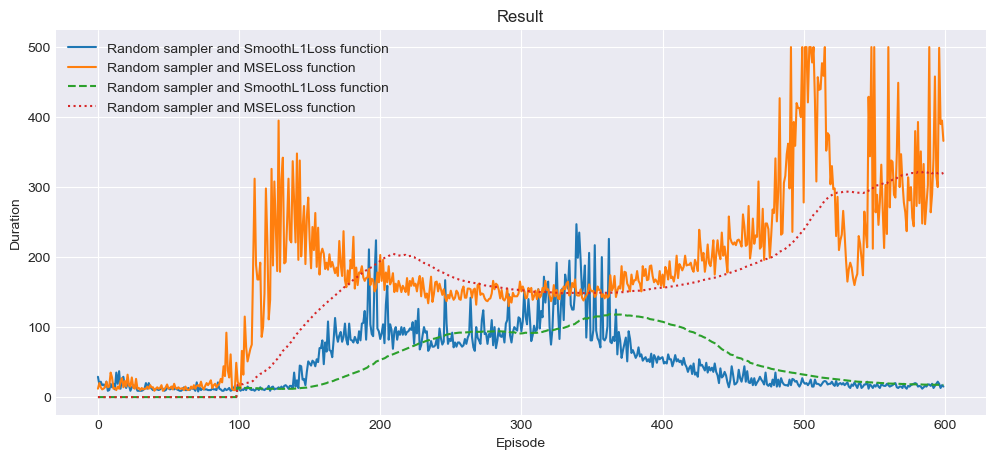

In [11]:
plot_durations_comparison(600,5,config)

On remarque que l'EQM, en moyenne, permet d'obtenir des temps d'épisode beaucoup plus longs qu'avec la smooth L1 (jusqu'à $\approx 13$ fois plus longtemps au 600ème épisode). Par conséquent, avec l'EQM, l'agent arrive à mieux à apprendre et performe mieux à chaque épisode. Ce qui est étrange, car la smooth L1 est moins sensible aux données aberrantes et permet de ne pas exploser la descente de gradient : il se peut que la valeur de beta (permettant de considérer si un point est un "outlier") par défaut (i.e 1) n'est pas adaptée. Par ailleurs, il se peut qu'aussi notre modèle ne soit pas si affecté par des données aberrantes ou qu'il faut, pour ce problème précis, chercher un modèle qui est suffisamment performant pour la majorité des données (ce qui est permis par l'EQM). Ainsi, l'EQM semble très bien adaptée à notre problème de cart.  